In [160]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 

# Кейс - Анализ пари на спорт

Я давно веду таблицу с результатами своих пари на спорт, играя по стратегии поиска исходов, на которые букмекером завышен коэффициент (вероятность происхождения события выше, чем считает букмекер)
1. Стало интересно проверить гипотезу о том, что пари по моей стратегии выигрывают чаще, чем были бы случайные результаты с вероятностями, выставленными букмекером.
2. Также мне интересна вторая гипотеза: ставки на футбол получаются хуже, чем на другие виды спорта. В процессе у меня складывается такое впечатление.

### Загрузка, подготовка данных и EDA

In [164]:
# Загрузка данных
bets = pd.read_excel('bets.xlsx')
bets.head()

,размер пари,дата,спорт,соревнования,двойка,тип,тип 2,кэф,проход
0,1,2023-04-22,футбол,франция,1.0,ОЗ,прематч,2.81,0
1,1,2023-04-22,хоккей,прочее,0.0,Результат,лайв,1.43,1
2,1,2023-04-22,теннис,мужчины,0.0,Результат,лайв,2.11,1
3,1,2023-04-22,хоккей,нхл - плоф,0.0,Результат,прематч,2.11,1
4,1,2023-04-22,футбол,Германия,0.0,Ауты,лайв,1.56,1


In [165]:
# инфо о колонках
bets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   размер пари   1314 non-null   object        
 1   дата          1319 non-null   datetime64[ns]
 2   спорт         1319 non-null   object        
 3   соревнования  1303 non-null   object        
 4   двойка        1314 non-null   float64       
 5   тип           1319 non-null   object        
 6   тип 2         1319 non-null   object        
 7   кэф           1319 non-null   float64       
 8   проход        1314 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 92.9+ KB


Видим, что часть колонок с численными значениям имеет строчный формат, что означает, что есть неверно заполненные строки, а также пропуски.    
Также названия колонок на русском, переименуем их для удобства работы

In [167]:
# Переименование колонок
names = {'размер пари' : 'bet', 'дата' : 'date', 'спорт' : 'sport',
         'соревнования' : 'competition', 'двойка' : 'twin', 'тип' : 'type1', 
         'тип 2' : 'type2', 'кэф' : 
         'coef', 'проход' : 'result'}
bets = bets.rename(columns=names)
bets.head()

,bet,date,sport,competition,twin,type1,type2,coef,result
0,1,2023-04-22,футбол,франция,1.0,ОЗ,прематч,2.81,0
1,1,2023-04-22,хоккей,прочее,0.0,Результат,лайв,1.43,1
2,1,2023-04-22,теннис,мужчины,0.0,Результат,лайв,2.11,1
3,1,2023-04-22,хоккей,нхл - плоф,0.0,Результат,прематч,2.11,1
4,1,2023-04-22,футбол,Германия,0.0,Ауты,лайв,1.56,1


In [168]:
bets.sport.unique()

array(['футбол', 'хоккей', 'теннис', 'Теннис', 'Футбол', 'дота',
       'формула 1', 'формула 1 - спринт', 'гандбол', nan, 'волейбол',
       'хокккей'], dtype=object)

In [169]:
# Сколько ставок на футбол
bets.query('sport == "футбол" or sport == "Футбол"').bet.count()

1089

In [170]:
# просмотр уникальных значений в графе размер ставки
bets.result.unique()

array([0, 1, 'возвр', 'взвр', 0.5, 0.25, nan, 0.75, 0.8, 0.2, 0.4, 0.6,
       0.7, 0.3], dtype=object)

Есть нечисловые значения, а также пропуски, нужно их убрать

In [172]:
# Убираем все неверно заполненные строки
bets = bets.drop(bets[bets['result'] == 'возвр'].index)
bets = bets.drop(bets[bets['result'] == 'взвр'].index)
bets = bets.dropna()

In [173]:
# Меняем формат столбик на числовой
bets['bet'] = bets['bet'].astype(float)
bets['result'] = bets['result'].astype(float)

In [174]:
bets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1214 entries, 0 to 1319
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   bet          1214 non-null   float64       
 1   date         1214 non-null   datetime64[ns]
 2   sport        1214 non-null   object        
 3   competition  1214 non-null   object        
 4   twin         1214 non-null   float64       
 5   type1        1214 non-null   object        
 6   type2        1214 non-null   object        
 7   coef         1214 non-null   float64       
 8   result       1214 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 94.8+ KB


### Создание нужных колонок для анализа

Результаты также показаны по размеру ставки, для верного расчета в дальнейшем нам надо заменить данные в этом столбике на формат:\
1 - выигрыш пари\
0 - проигрыш пари

In [177]:
results = list(bets['result'].unique())

In [178]:
# Заменяем значения в ячейках с неверным заполнением
for r in results:
    if 0 < r < 1:
        bets['result'] = bets['result'].replace(r, 1)

In [179]:
# Проверяем данные
bets['result'].unique()

array([0., 1.])

Расчет колонки с суммой реального выигрыша/проигрыша. Возьмем для удобства расчетов единичную ставку за 1000 руб. \
Для расчета нам надо: размер ставки * 1000 * коэф * результат - 1000 * размер ставки

In [181]:
# расчет по формуле и проверка данных
bets['win'] = bets.bet * 1000 * bets.coef * bets.result - 1000 * bets.bet
bets.head()

,bet,date,sport,competition,twin,type1,type2,coef,result,win
0,1.0,2023-04-22,футбол,франция,1.0,ОЗ,прематч,2.81,0.0,-1000.0
1,1.0,2023-04-22,хоккей,прочее,0.0,Результат,лайв,1.43,1.0,430.0
2,1.0,2023-04-22,теннис,мужчины,0.0,Результат,лайв,2.11,1.0,1110.0
3,1.0,2023-04-22,хоккей,нхл - плоф,0.0,Результат,прематч,2.11,1.0,1110.0
4,1.0,2023-04-22,футбол,Германия,0.0,Ауты,лайв,1.56,1.0,560.0


Расчет колонки с суммой случайного выигрыша/проигрыша согласно вероятности: \
Для этого нам надо создать колонку с вероятностью выигрыша: она будет равна вероятности по коэффициенту за минусом маржи букмекера (для удобства расчета будем считать, что букмекер в среднем выставляет коэффициент на 5% ниже рассчитанной им вероятности) \
Затем по этой вероятности будет расчитываться вероятность выигрыша или проигрыша каждого пари и случайный результат согласно этой вероятности будет вноситься в таблицу

In [183]:
# Расчет вероятности выигрыша по каждой строке
bets['prob'] = 1 / bets.coef - 0.05
bets.head()

,bet,date,sport,competition,twin,type1,type2,coef,result,win,prob
0,1.0,2023-04-22,футбол,франция,1.0,ОЗ,прематч,2.81,0.0,-1000.0,0.305872
1,1.0,2023-04-22,хоккей,прочее,0.0,Результат,лайв,1.43,1.0,430.0,0.649301
2,1.0,2023-04-22,теннис,мужчины,0.0,Результат,лайв,2.11,1.0,1110.0,0.423934
3,1.0,2023-04-22,хоккей,нхл - плоф,0.0,Результат,прематч,2.11,1.0,1110.0,0.423934
4,1.0,2023-04-22,футбол,Германия,0.0,Ауты,лайв,1.56,1.0,560.0,0.591026


In [184]:
# Колонка с потенциальным выигрышем по каждой строке для дальнейшего расчета
bets['pot_win'] = bets.bet * 1000 * bets.coef - 1000 * bets.bet
bets.head()

,bet,date,sport,competition,twin,type1,type2,coef,result,win,prob,pot_win
0,1.0,2023-04-22,футбол,франция,1.0,ОЗ,прематч,2.81,0.0,-1000.0,0.305872,1810.0
1,1.0,2023-04-22,хоккей,прочее,0.0,Результат,лайв,1.43,1.0,430.0,0.649301,430.0
2,1.0,2023-04-22,теннис,мужчины,0.0,Результат,лайв,2.11,1.0,1110.0,0.423934,1110.0
3,1.0,2023-04-22,хоккей,нхл - плоф,0.0,Результат,прематч,2.11,1.0,1110.0,0.423934,1110.0
4,1.0,2023-04-22,футбол,Германия,0.0,Ауты,лайв,1.56,1.0,560.0,0.591026,560.0


In [185]:
# Создание колонки со случайным результатом согласно рассчитаным ранее вероятностям
bets['win_random'] = bets.apply(lambda row: row['pot_win'] if np.random.rand() < row['prob'] else -1000*row['bet'], axis=1)
bets.head()

,bet,date,sport,competition,twin,type1,type2,coef,result,win,prob,pot_win,win_random
0,1.0,2023-04-22,футбол,франция,1.0,ОЗ,прематч,2.81,0.0,-1000.0,0.305872,1810.0,1810.0
1,1.0,2023-04-22,хоккей,прочее,0.0,Результат,лайв,1.43,1.0,430.0,0.649301,430.0,430.0
2,1.0,2023-04-22,теннис,мужчины,0.0,Результат,лайв,2.11,1.0,1110.0,0.423934,1110.0,-1000.0
3,1.0,2023-04-22,хоккей,нхл - плоф,0.0,Результат,прематч,2.11,1.0,1110.0,0.423934,1110.0,1110.0
4,1.0,2023-04-22,футбол,Германия,0.0,Ауты,лайв,1.56,1.0,560.0,0.591026,560.0,-1000.0


Целевые колонки созданы, можно переходить к статистическому анализу

### Визуализация данных и сравнение данных

Сначала можем просто посмотреть суммы в рублях по результатам реальных пари и случайно сгенерированных

In [189]:
bets['win'].sum()

16826.5

In [190]:
bets['win_random'].sum()

-127768.0

Видно, что реальные результаты лучше, но являются ли эта разница статистически значимой?

Описательные статистики

In [193]:
bets['win_random'].describe()

count    1214.000000
mean     -105.245470
std       820.312877
min     -1200.000000
25%     -1000.000000
50%      -200.000000
75%       680.000000
max      2050.000000
Name: win_random, dtype: float64

In [194]:
bets['win'].describe()

count    1214.000000
mean       13.860379
std       817.925884
min     -1200.000000
25%     -1000.000000
50%       385.000000
75%       720.000000
max      2900.000000
Name: win, dtype: float64

Визуализация

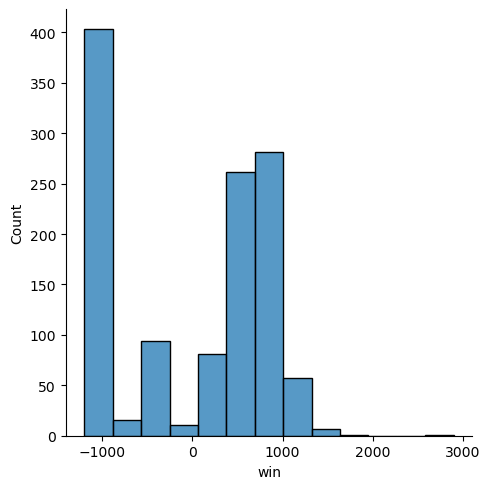

In [196]:
sns.displot(data=bets['win'])
plt.show()

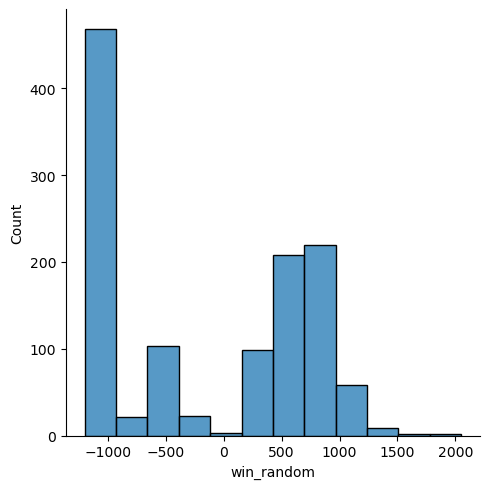

In [197]:
sns.displot(data=bets['win_random'])
plt.show()

По графикам также видно что левый хвост у случайных резульатов больше, а правый с выигрышами меньше

### Выбор теста

Сравнивать мы будем средние, так как медианы будут одинаковыми у обеих групп. Наши данные, очевидно, зависимы, так как пари выполнялись одним человеком, поэтому Т-тест мы отбрасывам, а вот Bootstrap может справиться с задачей.

В этом тесте мы будем смотреть 0,025 и 0,975 квантили на предмет наличия в них нуля. В случае если ноль будет включен в 95% доверительный интервал, то мы принимаем нулевую гипотезу о равенстве средних в случае же если нет, то мы можем принять альтернавтивную гипотезу

## Сравнение средних случайных результатов с фактическими результатами

In [203]:
mean_diff = []

for i in range(10000):
    sample_data_control = bets['win_random'].sample(frac=1, replace=True)
    sample_mean_control = sample_data_control.mean()
    
    
    sample_data_exp = bets['win'].sample(frac=1, replace=True)
    sample_mean_exp = sample_data_exp.mean()
    
    sample_mean_diff = sample_mean_exp - sample_mean_control
    mean_diff.append(sample_mean_diff)

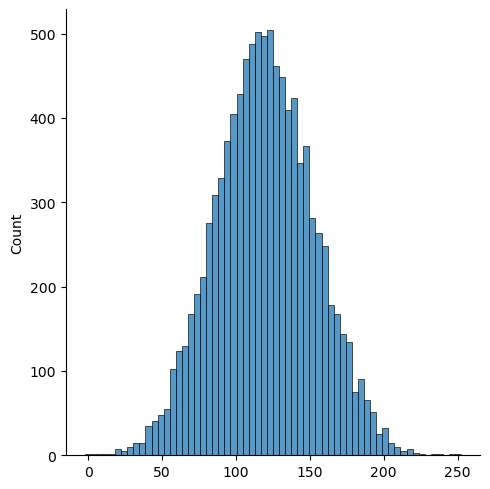

In [204]:
# Распределение средних на графике
sns.displot(mean_diff)
plt.show()

Квантили

In [206]:
pd.Series(mean_diff).quantile(0.975)

185.14258649093904

In [207]:
pd.Series(mean_diff).quantile(0.025)

55.82115939044481

Ноль не вошел в доверительный интервал, что позволяет нам сделать вывод о наличии различий в сравниваемых результатах. И по всем графикам и описательным статитикам мы видим, что фактические результаты лучше случайных по вероятностям от букмекера

### Подготовка данных для проверки второй гипотезы

In [210]:
# Создание колонки с разделением результатов на группы
bets['sport_group'] = bets.apply(lambda row: 1 if row['sport'] == 'футбол' or row['sport'] == 'Футбол' else 2, axis=1)
bets.head()

,bet,date,sport,competition,twin,type1,type2,coef,result,win,prob,pot_win,win_random,sport_group
0,1.0,2023-04-22,футбол,франция,1.0,ОЗ,прематч,2.81,0.0,-1000.0,0.305872,1810.0,1810.0,1
1,1.0,2023-04-22,хоккей,прочее,0.0,Результат,лайв,1.43,1.0,430.0,0.649301,430.0,430.0,2
2,1.0,2023-04-22,теннис,мужчины,0.0,Результат,лайв,2.11,1.0,1110.0,0.423934,1110.0,-1000.0,2
3,1.0,2023-04-22,хоккей,нхл - плоф,0.0,Результат,прематч,2.11,1.0,1110.0,0.423934,1110.0,1110.0,2
4,1.0,2023-04-22,футбол,Германия,0.0,Ауты,лайв,1.56,1.0,560.0,0.591026,560.0,-1000.0,1


### Визуализация данных и сравнение данных

In [212]:
bets.query('sport_group == 1').win.sum()

-353.0

In [213]:
bets.query('sport_group == 2').win.sum()

17179.5

Результаты по футболу даже в небольшом минусе, весь влюс в других видах спорта

In [215]:
bets.query('sport_group == 1').win.describe()

count    1012.000000
mean       -0.348814
std       805.218387
min     -1200.000000
25%     -1000.000000
50%       375.000000
75%       700.000000
max      1640.000000
Name: win, dtype: float64

In [216]:
bets.query('sport_group == 2').win.describe()

count     202.000000
mean       85.047030
std       877.478233
min     -1000.000000
25%     -1000.000000
50%       467.000000
75%       800.000000
max      2900.000000
Name: win, dtype: float64

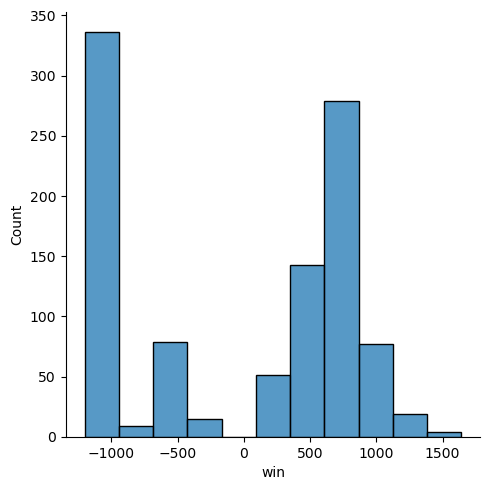

In [217]:
sns.displot(data=bets.query('sport_group == 1').win)
plt.show()

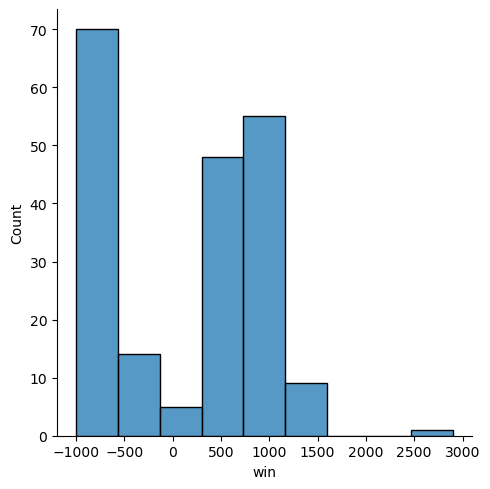

In [218]:
sns.displot(data=bets.query('sport_group == 2').win)
plt.show()

По графикам будто бы во второй группе ставок (не футбол) правый хвост с выгрышами относительно больше, но это сложно так оценить, тем более количество данных в каждой из групп разнится

### Выбор теста

Здесь все аналогично: данные зависимы, а сравнивать будем средние. Bootstrap наш выбор

## Сравнение средних результатов по футболу с другими видами спорта

In [223]:
mean_diff = []
bets_footbal = bets.query('sport_group == 1').win
bets_other = bets.query('sport_group == 2').win


for i in range(10000):
    sample_data_control = bets_footbal.sample(frac=1, replace=True)
    sample_mean_control = sample_data_control.mean()
    
    
    sample_data_exp = bets_other.sample(frac=1, replace=True)
    sample_mean_exp = sample_data_exp.mean()
    
    sample_mean_diff = sample_mean_exp - sample_mean_control
    mean_diff.append(sample_mean_diff)

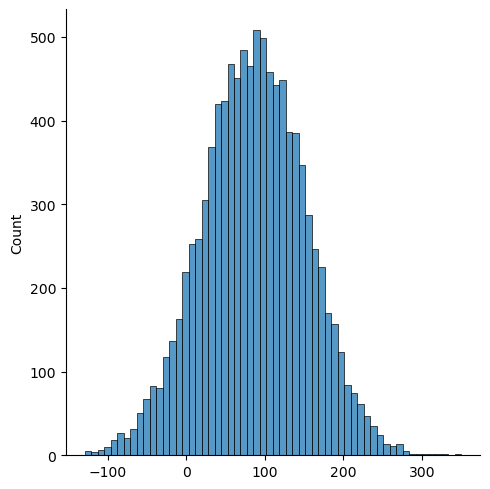

In [224]:
sns.displot(mean_diff)
plt.show()

In [225]:
pd.Series(mean_diff).quantile(0.975)

214.5185758521504

In [226]:
pd.Series(mean_diff).quantile(0.025)

-45.03319375415801

Ноль вошел в доверительный интервала, что значит, что мы принимаем нулевую гипотезу о равенстве средних в двух группах ставок. Хотя по графикам мы видим, что результаты по другим видам спорта выглядят лучше, чем по футболу, но этого недостаточно, чтобы сделать вывод о том, что стоит заниматься только ими

# Выводы

1. Резльутаты по пари по проводиму предварительному анализу коэффициентов лучше, чем ожидаемый случайный результат согласно выставленным коэффициентам
2. Данные не позволяют сделать вывод о том, что стваки на футбол даются хуже, чем на остальные виды спорта

### Что еще можно было бы сделать

1. Сравнить футбол не с остальными видами спорта, а все виды спорта между собой, отбросив те, где мало значений
2. Сравнить ставки по остальным колонкам данных (ставки во время мероприятия или заранее, ставки единичные или парой, по типам ставок внутри каждого спорта, анализ ставок по времени (сезонность и просиходит ли улучшение результатов со временем)
3. Но такое количество анализов обязательно привело бы к нахождению ошибочных значимых различий и требовало бы использования доп поправок на это. Я посмотрел самые интересные для себя пункты: сравнение результатов со случайным и футбола с остальным, что вызывало у меня вопросы в процессе сбора данных и занятия этим делом)